In [1]:
# ! pip install --upgrade paddlenlp -i https://pypi.org/simple

In [1]:
#导入相关的模块
import time
import os
import paddle
import paddlenlp as ppnlp
from paddlenlp.data import Stack, Pad, Tuple
import paddle.nn.functional as F
import numpy as np
from functools import partial 
import logging
#禁止输出日志
logging.disable(logging.CRITICAL)

c:\Users\12631\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 数据导入

In [5]:
# 导入所需的库
from paddlenlp.datasets import load_dataset

# 定义读取数据的函数
def read(data_path):
    cnt = 0
    with open(data_path, 'r', encoding='utf-8') as f:
        print(data_path)
        for line in f:
            # 从每一行中提取出文本和标签
            words, label = line.strip('\n').split('\t')

            cnt += 1

            # 使用yield生成器返回每个样本的字典形式
            yield {'text': words, 'label': label}
    print(cnt)

# 加载训练集、验证集和测试集数据
train_ds = load_dataset(read, data_path='训练集.txt', lazy=False)
dev_ds = load_dataset(read, data_path='验证集.txt', lazy=False)
test_ds = load_dataset(read, data_path='测试集.txt', lazy=False)

训练集.txt
28555
验证集.txt
3569
测试集.txt
3570


In [6]:
label_list = ['0', '1', '2', '3', '4', '5', '6']

print(label_list)
#打印数据集
print("训练集数据：{}\n".format(train_ds[0]))
print("验证集数据:{}\n".format(dev_ds[0]))
print("测试集数据:{}\n".format(test_ds[0]))

print("训练集样本个数:{}".format(len(train_ds)))
print("验证集样本个数:{}".format(len(dev_ds)))
print("测试集样本个数:{}".format(len(test_ds)))

['0', '1', '2', '3', '4', '5', '6']
训练集数据：{'text': '老板让直属秘书写某集团领导出国考察调研报告,秘书不会写,打电话求助我部领导帮写,我部领导分配我写,我连谁出国,几人出国,去哪出国,啥时出国一概不知,让我瞎编调研内容么?写错了我担责任么?更可笑的是,我向这位秘书了解具体行程,秘书很吃惊的回复,写这个报告需要这些内容吗?', 'label': '6'}

验证集数据:{'text': '手竟然被水寒剑打肿了qaq以后再也不想接打戏了,顿时觉得人生如此艰难otz', 'label': '6'}

测试集数据:{'text': '虽我没出众外表与才华,无很多财物,没很多知心朋友等,但我拥有爱我家人与关心我的朋友,有健康的体魄,有快乐的时光,等,下雨的时候我会不情不自禁地望着窗外想起我是多么的幸运,因为我有家人的疼爱,有避雨的地方,打雷下雨的时候还有无家可归的人。我就会感到辛酸!珍惜爱你的人[爱心]', 'label': '0'}

训练集样本个数:28555
验证集样本个数:3569
测试集样本个数:3570


# 数据预处理



In [2]:
# 使用预训练的BertTokenizer加载分词器
tokenizer = ppnlp.transformers.BertTokenizer.from_pretrained("bert-base-chinese")

# 定义转换样本的函数
def convert_example(example, tokenizer, label_list, max_seq_length=256, is_test=False):
    if is_test:
        text = example
    else:
        text = example['text']
        label = example['label']

    # 使用分词器对文本进行编码
    encoded_inputs = tokenizer.encode(text=text, max_seq_len=max_seq_length)

    input_ids = encoded_inputs["input_ids"]
    segment_ids = encoded_inputs["token_type_ids"]

    if not is_test:
        label_map = {}
        for (i, l) in enumerate(label_list):
            label_map[l] = i

        label = label_map[label]
        label = np.array([label], dtype="int64")
        return input_ids, segment_ids, label
    else:
        return input_ids, segment_ids

# 创建数据加载器函数
def create_dataloader(dataset, trans_fn=None, mode='train', batch_size=1, use_gpu=True, pad_token_id=0, batchify_fn=None):
    if trans_fn:
        dataset = dataset.map(trans_fn, lazy=True)

    if mode == 'train' and use_gpu:
        # 分布式批量采样器，用于训练模式下的GPU训练
        sampler = paddle.io.DistributedBatchSampler(dataset=dataset, batch_size=batch_size, shuffle=True)
    else:
        shuffle = True if mode == 'train' else False
        # 批量采样器，用于非训练模式下的数据加载
        sampler = paddle.io.BatchSampler(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    
    # 创建数据加载器
    dataloader = paddle.io.DataLoader(dataset, batch_sampler=sampler, return_list=True, collate_fn=batchify_fn)
    return dataloader

In [7]:
#使用partial()来固定convert_example函数的tokenizer, label_list, max_seq_length, is_test等参数值
trans_fn = partial(convert_example, tokenizer=tokenizer, label_list=label_list, max_seq_length=128, is_test=False)
batchify_fn = lambda samples, fn=Tuple(Pad(axis=0,pad_val=tokenizer.pad_token_id), Pad(axis=0, pad_val=tokenizer.pad_token_id), Stack(dtype="int64")):[data for data in fn(samples)]
#训练集迭代器
train_loader = create_dataloader(train_ds, mode='train', batch_size=64, batchify_fn=batchify_fn, trans_fn=trans_fn)
#验证集迭代器

dev_loader = create_dataloader(dev_ds, mode='dev', batch_size=64, batchify_fn=batchify_fn, trans_fn=trans_fn)
#测试集迭代器
test_loader = create_dataloader(test_ds, mode='test', batch_size=64, batchify_fn=batchify_fn, trans_fn=trans_fn)

# 模型加载

In [8]:
#加载预训练模型，由于情绪分为七类，num_classes=7
model = ppnlp.transformers.BertForSequenceClassification.from_pretrained("bert-base-chinese", num_classes=7)

# 模型训练

In [9]:
#参数设置
#学习率
learning_rate = 1e-5
#训练轮次
epochs = 10
#学习率预热比率
warmup_proption = 0.1
#权重衰减系数
weight_decay = 0.01
#绘制曲线图的数组
Iters, total_loss, total_acc = [], [], []
eval_accs=[]#评估验证集的准确率
eval_iter=[]

#模型的保存路径
model_path="model/"+time.strftime('%Y-%m-%d')+'/'+rf'lr={learning_rate}-epochs={epochs}-wp={warmup_proption}-wd={weight_decay}'

#测试数据记录路径
data_log_path="bert-base-chinese参数和结果记录.txt"

In [10]:
# 设置训练超参数
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(warmup_proption * num_training_steps)

def get_lr_factor(current_step):
    # 如果当前步数小于预热步数，则返回当前步数除以预热步数的比例
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    else:
        # 否则返回训练步数减去当前步数除以训练步数减去预热步数的比例
        return max(0.0,
                    float(num_training_steps - current_step) /
                    float(max(1, num_training_steps - num_warmup_steps)))

# 学习率调度器
lr_scheduler = paddle.optimizer.lr.LambdaDecay(learning_rate, lr_lambda=lambda current_step: get_lr_factor(current_step))

# 优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

# 损失函数
criterion = paddle.nn.loss.CrossEntropyLoss()

# 评估函数
metric = paddle.metric.Accuracy()

In [11]:
# 评估函数
def evaluate(model, criterion, metric, data_loader):
    model.eval()  # 设置模型为评估模式
    metric.reset()  # 重置评估指标
    losses = []  # 用于存储每个batch的损失值
    for batch_id, batch in enumerate(data_loader):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)  # 前向传播计算预测结果
        loss = criterion(logits, labels)  # 计算损失值
        losses.append(float(loss))  # 将损失值添加到列表中
        correct = metric.compute(logits, labels)  # 计算预测准确率
        metric.update(correct)  # 更新评估指标
        accu = metric.accumulate()  # 计算累积准确率
    print("eval loss: %.5f, accu: %.5f" % (np.mean(losses), accu))  # 打印评估结果
    model.train()  # 设置模型为训练模式
    metric.reset()  # 重置评估指标
    return np.mean(losses), accu  # 返回平均损失值和准确率

In [ ]:
# 开始训练
global_step = 0  # 全局迭代次数
best_acc = 0  # 最佳准确率
best_step = 0  # 最佳迭代步数
tic_train = time.time()  # 记录训练开始时间

for epoch in range(1, epochs + 1):  # 遍历每个epoch
    for step, batch in enumerate(train_loader):  # 从训练数据迭代器中取数据
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)  # 前向传播计算预测结果
        loss = criterion(logits, labels)  # 计算损失
        probs = F.softmax(logits, axis=1)  # 计算预测概率
        correct = metric.compute(probs, labels)  # 计算预测准确率
        metric.update(correct)  # 更新评估指标
        acc = metric.accumulate()  # 计算累积准确率

        global_step += 1  # 更新全局迭代次数
        if global_step % 50 == 0:
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        
        if global_step % 100 == 0:  # 每迭代100次，评估当前训练的模型、保存当前模型参数和分词器的词表等
            save_dir = model_path
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            print(global_step, end=' ')
            loss_eval, acc_eval = evaluate(model, criterion, metric, dev_loader)
            eval_accs.append(acc_eval)
            eval_iter.append(global_step)
            if acc_eval > best_acc:
                best_acc = acc_eval
                best_step = global_step
                model.save_pretrained(save_dir)
                tokenizer.save_pretrained(save_dir)

        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数
        lr_scheduler.step()  # 更新学习率
        optimizer.clear_gradients()  # 清除梯度

        if step % 50 == 0:  # 每100个batch输出一次结果
            Iters.append(global_step)
            total_loss.append(float(loss))
            total_acc.append(acc)

# evaluate(model, criterion, metric, dev_loader)

In [12]:
# 绘制曲线
import matplotlib.pyplot as plt
# 损失函数
def draw_process(title, color, iters, data, label, png_path):
    plt.title(title, fontsize=24)  # 设置标题
    plt.xlabel("iter", fontsize=20)  # 设置x轴标签
    plt.ylabel(label, fontsize=20)  # 设置y轴标签
    plt.plot(iters, data, color=color, label=label)  # 绘制曲线
    plt.legend()  # 显示图例
    plt.grid()  # 显示网格线
    plt.savefig(png_path+'/'+label+'.png')  # 保存图像
    plt.show()  # 显示图像

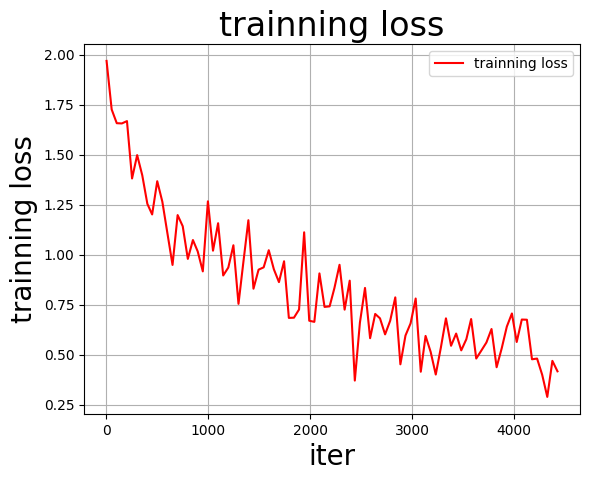

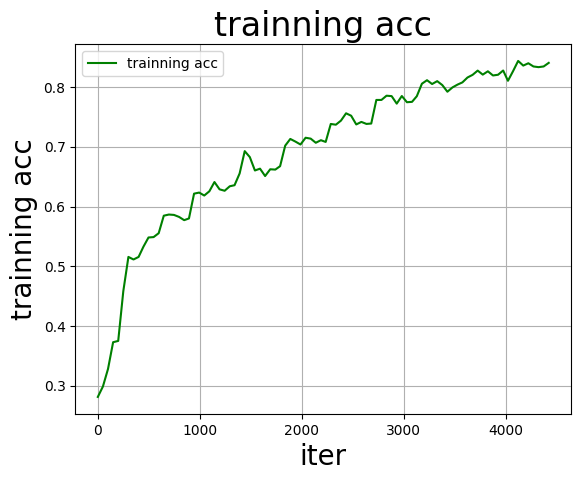

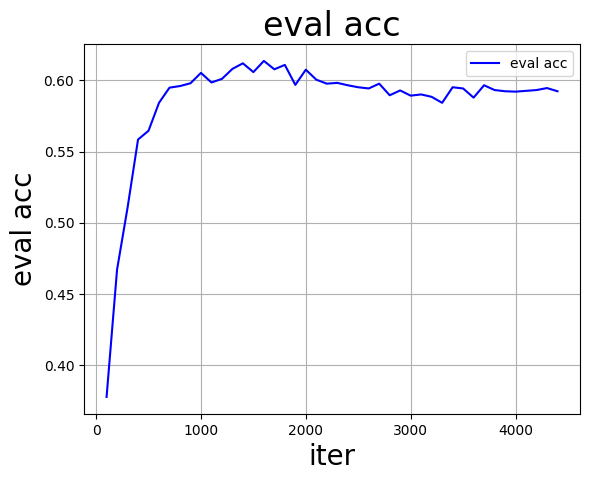

In [15]:

# 可视化查看
draw_process("trainning loss","red",Iters,total_loss,"trainning loss",model_path)
draw_process("trainning acc","green",Iters,total_acc,"trainning acc",model_path)
draw_process("eval acc","blue",eval_iter,eval_accs,"eval acc",model_path)

# 模型保存

​ 保存：

model.save_pretrained("./checkpoint')

tokenizer.save_pretrained("./checkpoint')


​ 加载：

model.from_pretrained("./checkpoint')

tokenizer.from_pretrained("./checkpoint')

In [16]:
#  加载：
load_path=model_path

model=model.from_pretrained(load_path)
tokenizer=tokenizer.from_pretrained(load_path)

# 模型验证

In [17]:
# 预测函数
def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    for text in data:
        input_ids, segment_ids = convert_example(text, tokenizer, label_list=label_map.values(),  max_seq_length=128, is_test=True)
        examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(Pad(axis=0, pad_val=tokenizer.pad_token_id), Pad(axis=0, pad_val=tokenizer.pad_token_id)): fn(samples)
    batches = []
    one_batch = []
    for example in examples:
        one_batch.append(example)
        if len(one_batch) == batch_size:
            batches.append(one_batch)
            one_batch = []
    if one_batch:
        batches.append(one_batch)

    results = []
    model.eval()  # 设置模型为评估模式
    for batch in batches:
        input_ids, segment_ids = batchify_fn(batch)
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)  # 前向传播计算预测结果
        probs = F.softmax(logits, axis=1)  # 计算预测概率
        idx = paddle.argmax(probs, axis=1).numpy()  # 获取预测结果的索引
        idx = idx.tolist()
        labels = [label_map[str(i)] for i in idx]  # 根据索引获取标签
        results.extend(labels)  # 将预测结果添加到列表中
    return results

# 模型评估

In [ ]:
#  加载模型：
load_path = model_path
# 从指定路径加载预训练模型，并将加载的模型赋值给model变量
model = model.from_pretrained(load_path)
# 从指定路径加载预训练分词器，并将加载的分词器赋值给tokenizer变量
tokenizer = tokenizer.from_pretrained(load_path)

In [ ]:
# 记录参数
# 调用evaluate函数，计算模型在测试集上的损失和准确率，并将结果分别赋值给eval_loss和eval_acc变量
eval_loss, eval_acc = evaluate(model=model, criterion=criterion, metric=metric, data_loader=test_loader) 
# 将eval_loss转换为浮点数，并保留小数点后5位
eval_loss = round(float(eval_loss), 5) 
# 将eval_acc转换为浮点数，并保留小数点后5位
eval_acc = round(float(eval_acc), 5) 

with open(data_log_path, 'a', encoding='utf-8') as f:
    # 构建一个字符串line，包含了学习率、迭代次数、预热比例、权重衰减、评估损失和评估准确率的信息
    line = rf'learning_rate={learning_rate}, epochs={epochs}, warmup_proption={warmup_proption}, weight_decay={weight_decay}, eval_loss={eval_loss}, eval_acc={eval_acc}' + '\n'
    f.write(line)
    # 将line写入到指定的文件中